In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-05-14 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression-*-

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

#!pip install grakel
from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm


tr = pd.read_csv( 'data/to_read.csv' )


In [2]:
tr.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [3]:
# Check how many times each book has been added to 'to read'
tr['book_id'].value_counts()

book_id
47      2772
143     1967
113     1840
13      1812
11      1767
        ... 
6297       1
7951       1
4434       1
9124       1
8946       1
Name: count, Length: 9986, dtype: int64

In [4]:
# Check how many times a book has only one user who added it to 'to read'
(tr['book_id'].value_counts() < 50).sum()

5641

In [7]:
# Create a dictionary where the keys are user_ids and the values are sets of book_ids
user_books = defaultdict(set)

# Populate the dictionary
for _, row in tqdm(tr.iterrows(), total=tr.shape[0]):
    user_books[row['user_id']].add(row['book_id'])


100%|██████████| 912705/912705 [00:30<00:00, 29822.97it/s]


In [8]:
import random

# Select a random subset of users
user_subset = random.sample(list(user_books.keys()), 100)

# Create an empty graph
G_user_books_sample = nx.Graph()

# Iterate over each user in the subset
for user_id in tqdm(user_subset, total=len(user_subset)):
    # Get the books for this user
    books = user_books[user_id]
    
    # Generate all pairs of books for this user
    book_pairs = combinations(books, 2)
    
    # Add edges between all pairs of books
    for book_pair in book_pairs:
        G_user_books_sample.add_edge(*book_pair, user_id=user_id)

# Print the number of nodes and edges in the sampled graph
print(len(G_user_books_sample.nodes()))
print(len(G_user_books_sample.edges()))

100%|██████████| 100/100 [00:00<00:00, 238.82it/s]

1469
32155


In [24]:
number_to_read =  tr['book_id'].value_counts()
number_to_read = number_to_read.apply(lambda x: 1 if x >= 100 else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [25]:
number_to_read.count()

9986

In [26]:
number_to_read.value_counts()

count
0    7713
1    2273
Name: count, dtype: int64

In [27]:
nx.set_node_attributes(G_user_books_sample, number_to_read.to_dict(), 'to_read')

In [28]:
# Can we compare what we have in graph_labels and what we have in the graph nodes ? 
# The answer is yes, we can compare the two lists and check if they are the same.
# We can do this by using the following code:
set(G_user_books_sample.nodes()).issubset(set(number_to_read.index))


True

In [29]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in G_user_books_sample.nodes(data=True):
    if node[1]['to_read'] == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

876 593


In [31]:
graph_labels = nx.get_node_attributes(G_user_books_sample, 'to_read')
graph_labels

{9539: 0,
 295: 1,
 106: 1,
 1901: 0,
 789: 1,
 8960: 0,
 1281: 1,
 2831: 1,
 146: 1,
 915: 1,
 1427: 1,
 1448: 1,
 3757: 0,
 1848: 1,
 2494: 1,
 703: 1,
 2500: 1,
 2262: 1,
 1628: 1,
 477: 1,
 3429: 1,
 1640: 0,
 617: 1,
 1770: 1,
 1001: 1,
 7662: 0,
 623: 1,
 244: 1,
 886: 1,
 2422: 1,
 2424: 1,
 1403: 1,
 2433: 0,
 385: 1,
 262: 1,
 6161: 0,
 791: 1,
 1436: 0,
 285: 1,
 668: 1,
 799: 0,
 38: 1,
 3879: 0,
 40: 1,
 1192: 1,
 551: 1,
 689: 1,
 567: 1,
 2872: 1,
 190: 1,
 1216: 1,
 320: 1,
 4420: 0,
 458: 1,
 4557: 0,
 979: 1,
 3155: 0,
 4950: 1,
 1110: 1,
 216: 1,
 8409: 1,
 3038: 1,
 352: 1,
 3553: 0,
 1130: 1,
 874: 1,
 749: 1,
 238: 1,
 111: 1,
 112: 1,
 2551: 1,
 896: 1,
 1030: 1,
 7943: 0,
 10: 1,
 651: 1,
 399: 1,
 3985: 1,
 274: 1,
 22: 1,
 2456: 0,
 158: 1,
 31: 1,
 5280: 0,
 161: 1,
 162: 1,
 289: 1,
 160: 1,
 1444: 1,
 1318: 0,
 671: 1,
 173: 1,
 815: 1,
 177: 1,
 435: 1,
 181: 1,
 185: 1,
 1082: 1,
 57: 1,
 1212: 1,
 3773: 0,
 446: 1,
 831: 1,
 1087: 1,
 321: 1,
 707: 1,
 32

In [34]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=G_user_books_sample.nodes())

# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(G_user_books_sample.degree()))

# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(G_user_books_sample))

# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(G_user_books_sample))

#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(G_user_books_sample))

# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(G_user_books_sample))

# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(G_user_books_sample))

# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(G_user_books_sample))

# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})


[0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1
 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1
 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1
 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1]
Accuracy:  0.6031746031746031
F1 Score:  0.6902654867256637


,Real,Predicted
7157,0,0
746,1,1
9004,0,0
238,1,1
63,1,1
...,...,...
595,1,0
297,1,1
140,1,1
4735,0,0


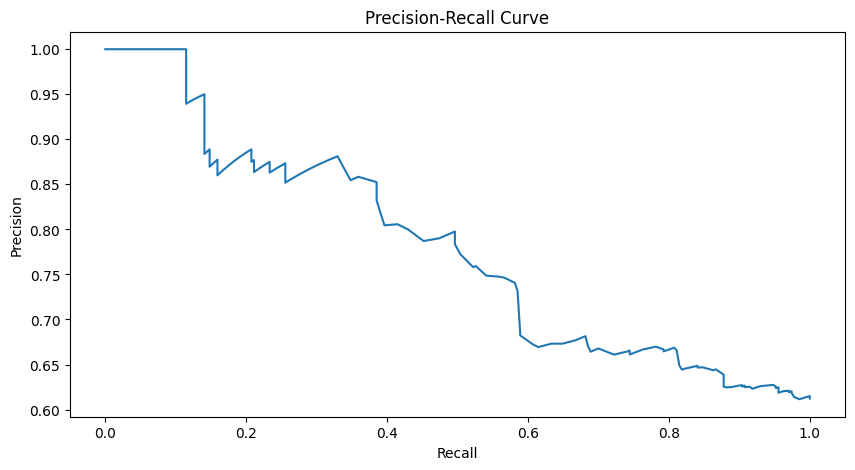

In [37]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities of the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Get the precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Use this threshold to predict the classes
y_pred = (y_scores > best_threshold).astype(int)

# Print the precision-recall curve for the model 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

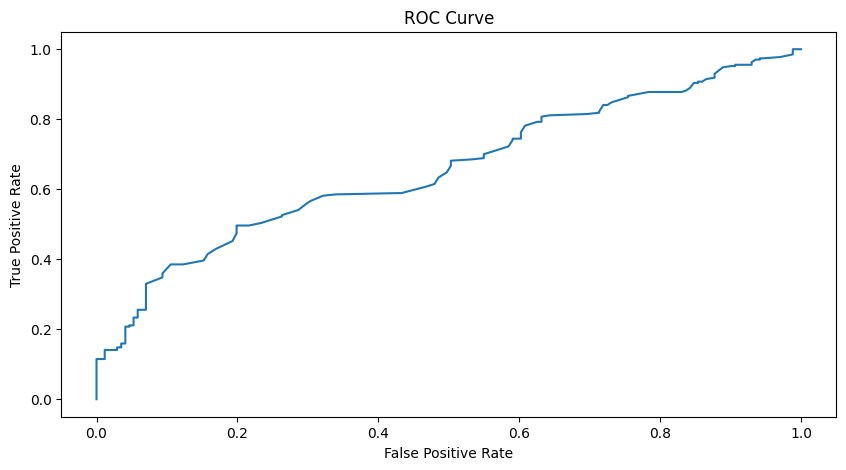

In [38]:
# Plot the ROC curve
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [39]:
node_features

,degree,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels
9539,4,0.312147,0.000000,1.000000,0.000737,0.000221,40.250000,0
295,75,0.419126,0.005900,0.475315,0.022604,0.001167,65.373333,1
106,78,0.422357,0.003318,0.578422,0.035303,0.001083,75.153846,1
1901,4,0.312147,0.000000,1.000000,0.000737,0.000221,40.250000,0
789,4,0.312147,0.000000,1.000000,0.000737,0.000221,40.250000,1
...,...,...,...,...,...,...,...,...
4169,23,0.343801,0.000000,1.000000,0.003457,0.000478,43.173913,0
6110,23,0.343801,0.000000,1.000000,0.003457,0.000478,43.173913,0
3681,23,0.343801,0.000000,1.000000,0.003457,0.000478,43.173913,0
4066,23,0.343801,0.000000,1.000000,0.003457,0.000478,43.173913,0


In [40]:
# Now can we try to make different combinaisons of features to see what has the best accuracy and F1 score and store the result in a datafram in order to print the best combinaison
from sklearn.metrics import f1_score

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])

# Iterate over all possible combinations of features
for i in range(1, len(node_features.columns) - 1):
    for features in combinations(node_features.columns[:-1], i):
        print(features)
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

        # Train a simple model
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the accuracy and F1 score of the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

       # Append the results to the DataFrame
        results.loc[len(results)] = [features, accuracy, f1]
        print(accuracy, f1)

# Print the results
results.sort_values('f1_score', ascending=False).head(10)

# Print the best combinaison
best_combinaison = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combinaison of features:")
print(best_combinaison['features'])
print("Accuracy:", best_combinaison['accuracy'])
print("F1 Score:", best_combinaison['f1_score'])


('degree',)
0.6190476190476191 0.6978417266187051
('closeness',)
0.6258503401360545 0.760522496371553
('betweenness',)
0.6122448979591837 0.759493670886076
('clustering',)
0.6122448979591837 0.759493670886076
('eigenvector',)
0.6122448979591837 0.759493670886076
('pagerank',)
0.6122448979591837 0.759493670886076
('average_neighbor_degree',)
0.5986394557823129 0.7103109656301146
('degree', 'closeness')
0.6145124716553289 0.7007042253521127
('degree', 'betweenness')
0.6190476190476191 0.6978417266187051
('degree', 'clustering')
0.6031746031746031 0.6823956442831216
('degree', 'eigenvector')
0.6190476190476191 0.6978417266187051
('degree', 'pagerank')
0.6190476190476191 0.6978417266187051
('degree', 'average_neighbor_degree')
0.6099773242630385 0.6884057971014493
('closeness', 'betweenness')
0.6258503401360545 0.760522496371553
('closeness', 'clustering')
0.6258503401360545 0.7401574803149606
('closeness', 'eigenvector')
0.6258503401360545 0.760522496371553
('closeness', 'pagerank')
0.625

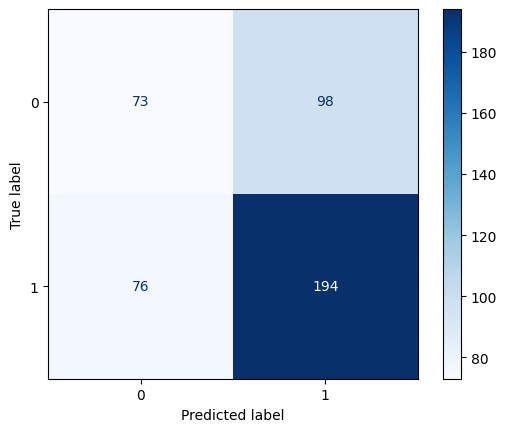

In [43]:
# Plot the matrix of confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()



In [44]:
# Make the same but with an other model 
from sklearn.ensemble import RandomForestClassifier

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features[list(best_combinaison['features'])], node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.6303854875283447
F1 Score:  0.7020109689213894


In [45]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1
 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1
 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0
 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0
 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0
 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1
 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0]
Accuracy:  0.6303854875283447
F1 Score:  0.7020109689213894


,Real,Predicted
7157,0,1
746,1,1
9004,0,0
238,1,1
63,1,1
...,...,...
595,1,1
297,1,1
140,1,1
4735,0,0


In [46]:
#Try with SVM
from sklearn.svm import SVC

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = SVC(probability=True)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0
 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1]
Accuracy:  0.63718820861678
F1 Score:  0.7297297297297297


,Real,Predicted
7157,0,1
746,1,1
9004,0,0
238,1,1
63,1,1
...,...,...
595,1,0
297,1,1
140,1,1
4735,0,0
